In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv(r'D:\ML_python\essay_summarizer\data_sets\train.tsv\train.tsv',sep='\t', encoding='ISO-8859-1')

In [4]:
df.head()

,Id,EssaySet,Score1,Score2,EssayText
0,1,1,1,1,Some additional information that we would need...
1,2,1,1,1,"After reading the expirement, I realized that ..."
2,3,1,1,1,"What you need is more trials, a control set up..."
3,4,1,0,0,The student should list what rock is better an...
4,5,1,2,2,For the students to be able to make a replicat...


In [5]:
df["Length"] = df['EssayText'].apply(lambda x: len(x.split(" ")))

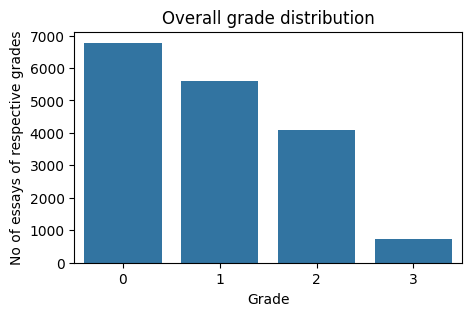

In [6]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Score1')
plt.title(f'Overall grade distribution')
plt.xlabel('Grade')
plt.ylabel('No of essays of respective grades')
plt.show()

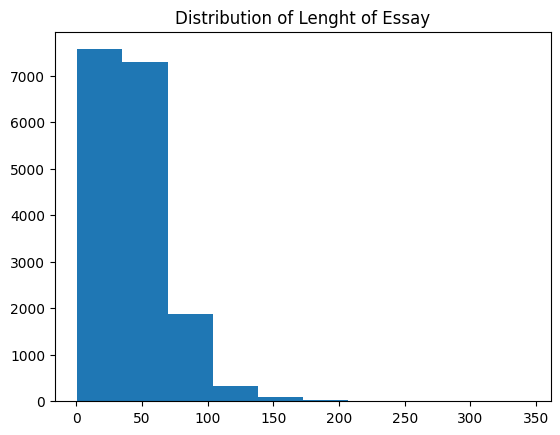

In [7]:
plt.hist(df["Length"])
plt.title("Distribution of Lenght of Essay")
plt.show()

In [8]:
grp = df.groupby(["Score1"]).agg({"Length":"mean"})
grp.reset_index(inplace=True)
grp

,Score1,Length
0,0,28.651424
1,1,43.225053
2,2,61.550920
3,3,63.071525


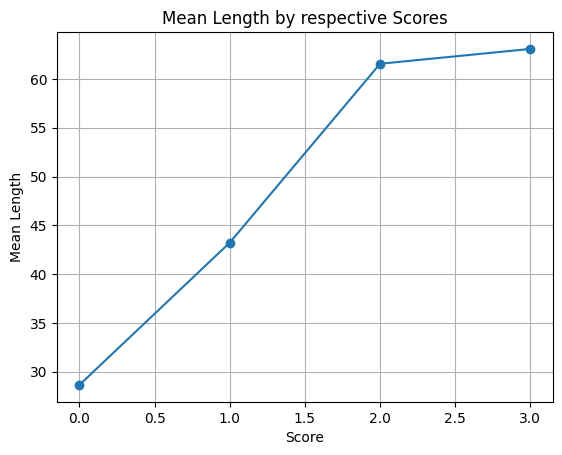

In [9]:
plt.plot(grp["Score1"], grp["Length"], marker='o', linestyle='-')
plt.xlabel("Score")
plt.ylabel("Mean Length")
plt.title("Mean Length by respective Scores")
plt.grid(True)
plt.show()

In [10]:

# Perform one-hot encoding
df_new = pd.get_dummies(df, columns=['EssaySet'])

In [11]:
df_new.head()

,Id,Score1,Score2,EssayText,Length,EssaySet_1,EssaySet_2,EssaySet_3,EssaySet_4,EssaySet_5,EssaySet_6,EssaySet_7,EssaySet_8,EssaySet_9,EssaySet_10
0,1,1,1,Some additional information that we would need...,56,True,False,False,False,False,False,False,False,False,False
1,2,1,1,"After reading the expirement, I realized that ...",48,True,False,False,False,False,False,False,False,False,False
2,3,1,1,"What you need is more trials, a control set up...",35,True,False,False,False,False,False,False,False,False,False
3,4,0,0,The student should list what rock is better an...,17,True,False,False,False,False,False,False,False,False,False
4,5,2,2,For the students to be able to make a replicat...,31,True,False,False,False,False,False,False,False,False,False


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pickle

In [15]:
config ={
    "max_seq_length": 120,
    "bert_model_name": "bert-base-uncased",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "loss": 'mean_squared_error',
    "metrics": [MeanAbsoluteError(), RootMeanSquaredError()],
}

In [16]:
bert_tokenizer = BertTokenizer.from_pretrained(config['bert_model_name'])
bert_model = TFBertModel.from_pretrained(config['bert_model_name'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [17]:
df_new.columns


Index(['Id', 'Score1', 'Score2', 'EssayText', 'Length', 'EssaySet_1',
       'EssaySet_2', 'EssaySet_3', 'EssaySet_4', 'EssaySet_5', 'EssaySet_6',
       'EssaySet_7', 'EssaySet_8', 'EssaySet_9', 'EssaySet_10'],
      dtype='object')

In [18]:
# creating main feature list
main_fea = ['EssayText','Length',]

for i in range(1,11):
    main_fea.append('EssaySet_'+str(i))

main_fea

['EssayText',
 'Length',
 'EssaySet_1',
 'EssaySet_2',
 'EssaySet_3',
 'EssaySet_4',
 'EssaySet_5',
 'EssaySet_6',
 'EssaySet_7',
 'EssaySet_8',
 'EssaySet_9',
 'EssaySet_10']

In [19]:
# Extract chosen data
X = df_new[main_fea]

y = df_new['Score1']

In [20]:
X.columns

Index(['EssayText', 'Length', 'EssaySet_1', 'EssaySet_2', 'EssaySet_3',
       'EssaySet_4', 'EssaySet_5', 'EssaySet_6', 'EssaySet_7', 'EssaySet_8',
       'EssaySet_9', 'EssaySet_10'],
      dtype='object')

In [21]:
# Define the indexes for different feature types
text_colums_indexes = 0
numerical_columns_indexes = [1]
binary_columns_indexes = [i for i in range(2,12)]

In [22]:
binary_columns_indexes

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [23]:
#Dividing data into train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, y,
    test_size=0.1,
    shuffle=True,
    stratify=y,
    random_state=42
)

In [24]:
# Extract features
text_features_train = X_train[:, text_colums_indexes]
text_features_test = X_test[:, text_colums_indexes]

numerical_features_train = X_train[:, numerical_columns_indexes]
numerical_features_test = X_test[:, numerical_columns_indexes]

binary_features_train = X_train[:, binary_columns_indexes]
binary_features_test = X_test[:, binary_columns_indexes]

In [25]:
# Tokenize the text features with padding and truncation
input_ids_train = bert_tokenizer(list(text_features_train), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']
input_ids_test = bert_tokenizer(list(text_features_test), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']

In [26]:
# Standartize the numerical data
scaler = StandardScaler()
numerical_features_train_std = scaler.fit_transform(numerical_features_train)
numerical_features_test_std = scaler.transform(numerical_features_test)

# Save the scaler to a file
with open('scaler_config.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [28]:
# Gather all the features to one dictionary
X_train_dict = {
    "input_ids": input_ids_train,
    "numerical_features": numerical_features_train_std.astype(np.float32),
    "binary_features": binary_features_train.astype(np.float32)
}

X_test_dict = {
    "input_ids": input_ids_test,
    "numerical_features": numerical_features_test_std.astype(np.float32),
    "binary_features": binary_features_test.astype(np.float32)
}

Defining The Model

In [29]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="numerical_features")
binary_features = tf.keras.layers.Input(shape=(10,), dtype=tf.float32, name="binary_features")

# BERT embedding layer
pooler_output = bert_model(input_ids)[1]     # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features, binary_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_num_binary_model = tf.keras.models.Model(inputs=[input_ids, numerical_features, binary_features], outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_num_binary_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_num_binary_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 120)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 )                           ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 120, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                       

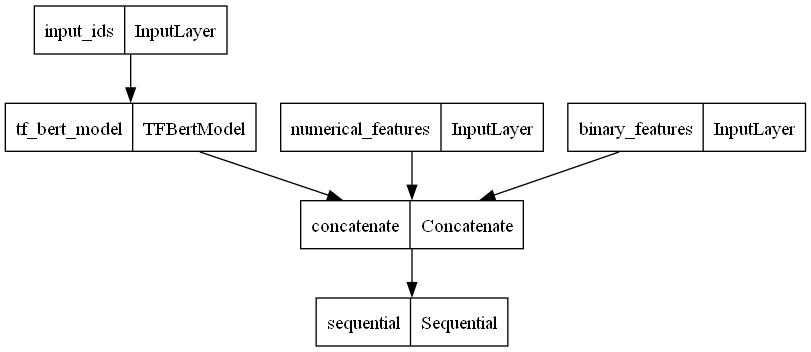

In [30]:
tf.keras.utils.plot_model(bert_num_binary_model)

In [31]:
# Define a callback to perform early stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0,         # Minimum change in validation loss to be considered an improvement
    patience=3,          # Number of epochs with no improvement after which training will stop
    verbose=0,           # Verbosity mode (0 for silent)
    mode='auto'          # Automatically infer the direction of loss improvement
)

In [32]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert_num_bin = tf.keras.callbacks.ModelCheckpoint(
    filepath='training_bert_num_bin/cp.ckpt',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert_num_bin = bert_num_binary_model.fit([X_train_dict['input_ids'], X_train_dict['numerical_features'], X_train_dict['binary_features']],
    y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_test_dict, y_test),
    callbacks=[checkpoint_callback_bert_num_bin, earlystop_callback])

Epoch 1/50

484/484 [==============================] - ETA: 0s - loss: 0.6661 - mean_absolute_error: 0.6560 - root_mean_squared_error: 0.8161
Epoch 1: val_loss improved from inf to 0.54774, saving model to training_bert_num_bin\cp.ckpt
INFO:tensorflow:Assets written to: training_bert_num_bin\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_bert_num_bin\cp.ckpt\assets


484/484 [==============================] - 1530s 3s/step - loss: 0.6661 - mean_absolute_error: 0.6560 - root_mean_squared_error: 0.8161 - val_loss: 0.5477 - val_mean_absolute_error: 0.5736 - val_root_mean_squared_error: 0.7401
Epoch 2/50
484/484 [==============================] - ETA: 0s - loss: 0.5898 - mean_absolute_error: 0.6107 - root_mean_squared_error: 0.7680
Epoch 2: val_loss improved from 0.54774 to 0.51006, saving model to training_bert_num_bin\cp.ckpt
INFO:tensorflow:Assets written to: training_bert_num_bin\cp.ckpt\assets


INFO:tensorflow:Assets written to: training_bert_num_bin\cp.ckpt\assets


484/484 [==============================] - 1503s 3s/step - loss: 0.5898 - mean_absolute_error: 0.6107 - root_mean_squared_error: 0.7680 - val_loss: 0.5101 - val_mean_absolute_error: 0.5839 - val_root_mean_squared_error: 0.7142
Epoch 3/50
484/484 [==============================] - ETA: 0s - loss: 0.5656 - mean_absolute_error: 0.5984 - root_mean_squared_error: 0.7520 
Epoch 3: val_loss improved from 0.51006 to 0.49526, saving model to training_bert_num_bin\cp.ckpt
